In [5]:
from __future__ import division, print_function

import lib.xmlreader as xml
import lib.utils as ut
import numpy as np

import gensim.models.word2vec
import itertools
from collections import Counter
from nltk.tokenize import word_tokenize

import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
import collections
import numpy as np
import matplotlib.pyplot as plt
import operator
import os
%matplotlib inline

In [6]:
train_docs= xml.readXML("../database/TASS/TASS2017/task1-Training.xml")
#len(train_docs)

In [7]:
test_docs= xml.readXML("../database/TASS/TASS2017/task1-Development.xml")
# train_docs = train_docs[0:700]
# test_docs = train_docs[-300:]

In [8]:
corpus = []
for doc in train_docs + test_docs:
    corpus.append(doc.content)

In [9]:
tokenized_train_docs = []
for doc in train_docs:
    tokenized_train_docs.append(ut.tokenize(doc.content, doc.polarity))
    
tokenized_test_docs = []
for doc in test_docs:
    tokenized_test_docs.append(ut.tokenize(doc.content, doc.polarity))

In [10]:
train_tweets = []
train_labels = []
for tweet in tokenized_train_docs:
    train_tweets.append(tweet['words'])
    train_labels.append(tweet['class'])

train_tweets = np.array(train_tweets)
train_labels = np.array(train_labels)

# train_tweets, test_tweets, train_labels, test_labels = ut.crossValidation2(tweets, labels, 3)

In [11]:
test_tweets = []
test_labels = []
for tweet in tokenized_test_docs:
    test_tweets.append(tweet['words'])
    test_labels.append(tweet['class'])

test_tweets = np.array(test_tweets)
test_labels = np.array(test_labels)

In [12]:
def CountFrequency(sentences): 
  
    # Creating an empty dictionary  
    freq = {} 
    for s in sentence:
        for item in my_list: 
            if (item in freq): 
                freq[item] += 1
            else: 
                freq[item] = 1
                
  
    for key, value in freq.items(): 
        print ("% d : % d"%(key, value)) 
        
    return freq

In [13]:
def map_word_frequency(list_of_words):
    return Counter(itertools.chain(*list_of_words))

In [14]:
word_counts = map_word_frequency(np.concatenate([train_tweets, test_tweets]))

In [15]:
train_labels.shape

(736,)

In [16]:
def gensim_load_vec(path="data/SBW-vectors-300-min5.bin"):
    #use gensim_emb.wv.index2word if used this way to load vectors
    #gensim_emb = gensim.models.word2vec.Word2Vec.load(path)
    gensim_emb =  gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
    vocab = gensim_emb.index2word
    vec = gensim_emb.syn0
    shape = gensim_emb.syn0.shape
    return gensim_emb, vec, shape, vocab

In [17]:
gensim_emb, vec, shape, vocab = gensim_load_vec("../database/embeddings/SBW-vectors-300-min5.bin")

/home/jose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  
/home/jose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  import sys


In [ ]:
# sent_emb = sentence2vec(sent_list,300,gensim_emb)

## Estimate Vocabulary Size

In [18]:
counter = CountVectorizer(strip_accents="unicode")

In [19]:
X = counter.fit_transform(corpus)
print(X.shape)

(1111, 5081)


Text(0.5, 0, 'words')

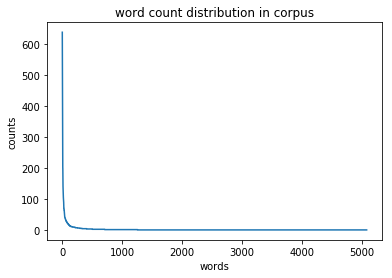

In [20]:
counts = np.sum(X, axis=0).tolist()
counts = sorted(counts[0], reverse=True)
plt.plot(np.arange(len(counts)), counts)
plt.title("word count distribution in corpus")
plt.ylabel("counts")
plt.xlabel("words")

## Compute Baseline Embedding (BoW)

<a href="https://www.codecogs.com/eqnedit.php?latex=v_s&space;=&space;\frac{1}{\left&space;\|&space;S&space;\right&space;\|}&space;\sum_{w&space;\in&space;S}&space;v_w" target="_blank"><img src="https://latex.codecogs.com/gif.latex?v_s&space;=&space;\frac{1}{\left&space;\|&space;S&space;\right&space;\|}&space;\sum_{w&space;\in&space;S}&space;v_w" title="v_s = \frac{1}{\left \| S \right \|} \sum_{w \in S} v_w" /></a>

In [21]:
# VOCAB_SIZE = 5877
# VOCAB_SIZE = 3313
VOCAB_SIZE = X.shape[1]
# counter = CountVectorizer(strip_accents="unicode", max_features=VOCAB_SIZE)
counter = CountVectorizer(max_features=VOCAB_SIZE)

caption_texts = corpus
Xc = counter.fit_transform(caption_texts).todense().astype("float")
print(Xc.shape)

(1111, 5081)


In [22]:
sent_lens = np.sum(Xc, axis=1).astype("float")
sent_lens[sent_lens == 0] = 1e-14
print(sent_lens.shape)

(1111, 1)


In [23]:
E = np.zeros((VOCAB_SIZE, 300))
for word in list(counter.vocabulary_.keys()):
    try:
        i = counter.vocabulary_[word]
        E[i] = gensim_emb[word]
    except KeyError:
        pass
print(E.shape)

(5081, 300)


In [24]:
Xb = np.divide(np.dot(Xc, E), sent_lens)
print(Xb.shape)

(1111, 300)


In [25]:
Xtrain, Xtest = Xb[0:len(train_docs)], Xb[-len(test_docs):]
ytrain, ytest = np.array(train_labels), np.array(test_labels)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

(736, 300) (736,) (375, 300) (375,)


In [26]:
def cross_val(Xtrain, ytrain, clf):
    best_clf = None
    best_score = 0.0
    num_folds = 0
    
    cv_scores = []
    kfold = KFold(n_splits=10)
    
    for train, val in kfold.split(Xtrain):
        Xctrain, Xctest, yctrain, yctest = Xtrain[train], Xtrain[val], ytrain[train], ytrain[val]
        clf.fit(Xctrain, yctrain)
        score = clf.score(Xctest, yctest)
        if score > best_score:
            best_score = score
            best_clf = clf
        print("fold {:d}, score: {:.3f}".format(num_folds, score))
        cv_scores.append(score)
        num_folds += 1
    return best_clf, cv_scores
    

def test_eval(Xtest, ytest, clf):
    print("===")
    print("Test set results")
    ytest_ = clf.predict(Xtest)
    accuracy = accuracy_score(ytest, ytest_)
    print("Accuracy: {:.3f}".format(accuracy))
    print("---")
    print("Confusion Matrix")
    cm = confusion_matrix(ytest, ytest_)
    print(cm)
    print("---")
    print("Classification Report")
    cr = classification_report(ytest, ytest_)
    print(cr)

In [27]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

best_clf, scores_nb = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.635
fold 1, score: 0.649
fold 2, score: 0.757
fold 3, score: 0.730
fold 4, score: 0.757
fold 5, score: 0.770
fold 6, score: 0.712
fold 7, score: 0.726
fold 8, score: 0.630
fold 9, score: 0.699
===
Test set results
Accuracy: 0.661
---
Confusion Matrix
[[158  61]
 [ 66  90]]
---
Classification Report
              precision    recall  f1-score   support

           1       0.71      0.72      0.71       219
           2       0.60      0.58      0.59       156

   micro avg       0.66      0.66      0.66       375
   macro avg       0.65      0.65      0.65       375
weighted avg       0.66      0.66      0.66       375



In [28]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
best_clf, scores_svc = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.730
fold 1, score: 0.757
fold 2, score: 0.770
fold 3, score: 0.730
fold 4, score: 0.824
fold 5, score: 0.662
fold 6, score: 0.712
fold 7, score: 0.822
fold 8, score: 0.685
fold 9, score: 0.753
===
Test set results
Accuracy: 0.717
---
Confusion Matrix
[[170  49]
 [ 57  99]]
---
Classification Report
              precision    recall  f1-score   support

           1       0.75      0.78      0.76       219
           2       0.67      0.63      0.65       156

   micro avg       0.72      0.72      0.72       375
   macro avg       0.71      0.71      0.71       375
weighted avg       0.72      0.72      0.72       375



In [29]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=5)
best_clf, scores_svc = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.743
fold 1, score: 0.784
fold 2, score: 0.757
fold 3, score: 0.757
fold 4, score: 0.838
fold 5, score: 0.662
fold 6, score: 0.685
fold 7, score: 0.877
fold 8, score: 0.644
fold 9, score: 0.726
===
Test set results
Accuracy: 0.709
---
Confusion Matrix
[[167  52]
 [ 57  99]]
---
Classification Report
              precision    recall  f1-score   support

           1       0.75      0.76      0.75       219
           2       0.66      0.63      0.64       156

   micro avg       0.71      0.71      0.71       375
   macro avg       0.70      0.70      0.70       375
weighted avg       0.71      0.71      0.71       375



## Smooth Inverse Frequency (SIF) Embedding

<a href="https://www.codecogs.com/eqnedit.php?latex=v_s&space;=&space;\frac{1}{\left&space;\|&space;S&space;\right&space;\|}&space;\sum_{w&space;\in&space;S}&space;\frac{\alpha}{\alpha&space;&plus;&space;p_w}&space;v_w" target="_blank"><img src="https://latex.codecogs.com/gif.latex?v_s&space;=&space;\frac{1}{\left&space;\|&space;S&space;\right&space;\|}&space;\sum_{w&space;\in&space;S}&space;\frac{\alpha}{\alpha&space;&plus;&space;p_w}&space;v_w" title="v_s = \frac{1}{\left \| S \right \|} \sum_{w \in S} \frac{\alpha}{\alpha + p_w} v_w" /></a>

In [30]:
# from paper
ALPHA = 1e-3

In [31]:
# # compute word probabilities from corpus
freqs = np.sum(Xc, axis=0).astype("float")
probs = freqs / np.sum(freqs)

In [32]:
# compute multiplier ALPHA / (ALPHA + probs)
coeff = ALPHA / (ALPHA + probs)

In [33]:
# compute weighted counts
Xw = np.multiply(Xc, coeff)

In [34]:
# convert to SIF embeddings
Xs = np.divide(np.dot(Xw, E), sent_lens)

print(Xc.shape, coeff.shape, Xs.shape, E.shape)

(1111, 5081) (1, 5081) (1111, 300) (5081, 300)


In [35]:
# compute 1st principal component
svd = TruncatedSVD(n_components=1, n_iter=20, random_state=0)
svd.fit(Xs)
pc = svd.components_
print(pc.shape, svd.explained_variance_ratio_)

(1, 300) [0.07982065]


In [36]:
# remove it from the weighted counts
Xr = Xs - Xs.dot(pc.T).dot(pc)
print(Xr.shape)

(1111, 300)


In [37]:
Xtrain, Xtest = Xr[0:len(train_docs)], Xr[-len(test_docs):]
ytrain, ytest = np.array(train_labels), np.array(test_labels)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

(736, 300) (736,) (375, 300) (375,)


In [38]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
best_clf, scores_nb = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.676
fold 1, score: 0.662
fold 2, score: 0.743
fold 3, score: 0.689
fold 4, score: 0.865
fold 5, score: 0.649
fold 6, score: 0.753
fold 7, score: 0.795
fold 8, score: 0.712
fold 9, score: 0.753
===
Test set results
Accuracy: 0.717
---
Confusion Matrix
[[157  62]
 [ 44 112]]
---
Classification Report
              precision    recall  f1-score   support

           1       0.78      0.72      0.75       219
           2       0.64      0.72      0.68       156

   micro avg       0.72      0.72      0.72       375
   macro avg       0.71      0.72      0.71       375
weighted avg       0.72      0.72      0.72       375



In [39]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
best_clf, scores_svc = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.703
fold 1, score: 0.730
fold 2, score: 0.770
fold 3, score: 0.757
fold 4, score: 0.797
fold 5, score: 0.635
fold 6, score: 0.712
fold 7, score: 0.808
fold 8, score: 0.630
fold 9, score: 0.753
===
Test set results
Accuracy: 0.715
---
Confusion Matrix
[[168  51]
 [ 56 100]]
---
Classification Report
              precision    recall  f1-score   support

           1       0.75      0.77      0.76       219
           2       0.66      0.64      0.65       156

   micro avg       0.71      0.71      0.71       375
   macro avg       0.71      0.70      0.70       375
weighted avg       0.71      0.71      0.71       375



In [40]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=0.9)
best_clf, scores_svc = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.676
fold 1, score: 0.730
fold 2, score: 0.757
fold 3, score: 0.743
fold 4, score: 0.784
fold 5, score: 0.703
fold 6, score: 0.726
fold 7, score: 0.740
fold 8, score: 0.671
fold 9, score: 0.753
===
Test set results
Accuracy: 0.728
---
Confusion Matrix
[[186  33]
 [ 69  87]]
---
Classification Report
              precision    recall  f1-score   support

           1       0.73      0.85      0.78       219
           2       0.72      0.56      0.63       156

   micro avg       0.73      0.73      0.73       375
   macro avg       0.73      0.70      0.71       375
weighted avg       0.73      0.73      0.72       375



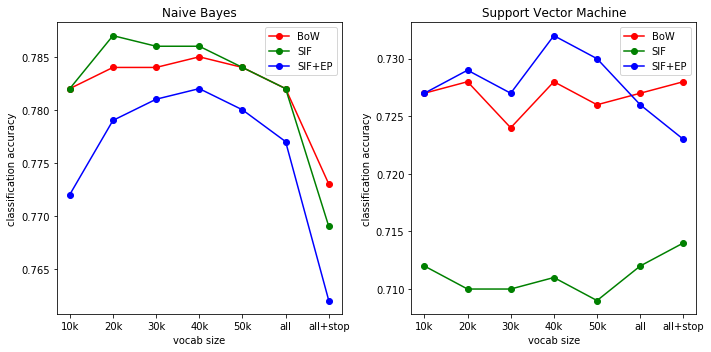

In [41]:
xlabels = ["10k", "20k", "30k", "40k", "50k", "all", "all+stop"]
# xs = [10000, 20000, 30000, 40000, 50000, 64170, 64450]
# we have changed the actual numbers to evenly space the points
xs = [10000, 20000, 30000, 40000, 50000, 60000, 70000]

ylabels = ["BoW/NB", "BoW/SVM", "SIF/NB", "SIF/SVM", 
           "SIF+EP/NB", "SIF+EP/SVM"]
ys = np.array(
        [[0.782, 0.784, 0.784, 0.785, 0.784, 0.782, 0.773],
         [0.727, 0.728, 0.724, 0.728, 0.726, 0.727, 0.728],
         [0.782, 0.787, 0.786, 0.786, 0.784, 0.782, 0.769],
         [0.712, 0.710, 0.710, 0.711, 0.709, 0.712, 0.714],
         [0.772, 0.779, 0.781, 0.782, 0.780, 0.777, 0.762],
         [0.727, 0.729, 0.727, 0.732, 0.730, 0.726, 0.723]])
ids_nb = [i for i, y in enumerate(ylabels) if y.endswith("/NB")]
labels_nb = [y.split("/")[0] for y in ylabels if y.endswith("/NB")]
ids_svm = [i for i, y in enumerate(ylabels) if y.endswith("/SVM")]
labels_svm = [y.split("/")[0] for y in ylabels if y.endswith("/SVM")]
colors = ["r", "g", "b"]

plt.figure(figsize=(10, 5))

plt.subplot(121)
curr_row = 0
for row in ids_nb:
    plt.plot(xs, ys[row, :], marker="o", 
             color=colors[curr_row], label=labels_nb[curr_row])
    curr_row += 1
plt.xticks(xs, xlabels)
plt.title("Naive Bayes")
plt.ylabel("classification accuracy")
plt.xlabel("vocab size")
plt.legend(loc="best")

plt.subplot(122)
curr_row = 0
for row in ids_svm:
    plt.plot(xs, ys[row, :], marker="o", 
             color=colors[curr_row], label=labels_svm[curr_row])
    curr_row += 1
plt.xticks(xs, xlabels)
plt.title("Support Vector Machine")
plt.ylabel("classification accuracy")
plt.xlabel("vocab size")
plt.legend(loc="best")

plt.tight_layout()
plt.show()